In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys

sys.path.insert(0,  '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, plot_performance, score2
from compass.tokenizer import CANCER_CODE
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [3]:
from compass.tokenizer import CONCEPT_palette

In [4]:
import shap
import torch
import torch.nn as nn
from shap import DeepExplainer, KernelExplainer
torch.manual_seed(0)

In [5]:
shap.__version__, np.__version__

('0.44.1', '1.24.3')

In [6]:
## read data
df_label = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.PATIENT.TABLE')
df_tpm = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.TPM.TABLE')
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [7]:
s = df_label.groupby('cohort').size()
cancer_type = '_'.join(df_label.cancer_type.unique())

df_tpm = df_tpm.loc[df_label.index]
dfcx_org = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
df_task = onehot(df_label.response_label)

In [8]:
df_label.cohort.unique()

array(['IMVigor210', 'Rose', 'Snyder', 'Zhao', 'Choueiri', 'IMmotion150',
       'Miao', 'SU2CLC1', 'SU2CLC2', 'Allen', 'Gide', 'Hugo', 'Liu',
       'MGH', 'Riaz', 'Kim'], dtype=object)

In [9]:
ls /home/was966/Research/mims-conceptor/paper/checkpoint/latest/

finetuner_lft_0.8.pt         finetuner_pft_all_v100s.pt  finetuner_pft_SKCM.pt
finetuner_lft_all.pt         finetuner_pft_BLCA.pt       finetuner_pft_STAD.pt
finetuner_pft_0.8.pt         finetuner_pft_GBM.pt        finetuner.pt
finetuner_pft_all.bak.pt     finetuner_pft_KIRC.pt       name.ipynb
finetuner_pft_all.pt         finetuner_pft_LUAD.pt       pretrainer.pt
finetuner_pft_all_v100s2.pt  finetuner_pft_LUSC.pt       tmpignore/


100%|##########| 36/36 [00:02<00:00, 16.51it/s]


  0%|          | 0/1133 [00:00<?, ?it/s]

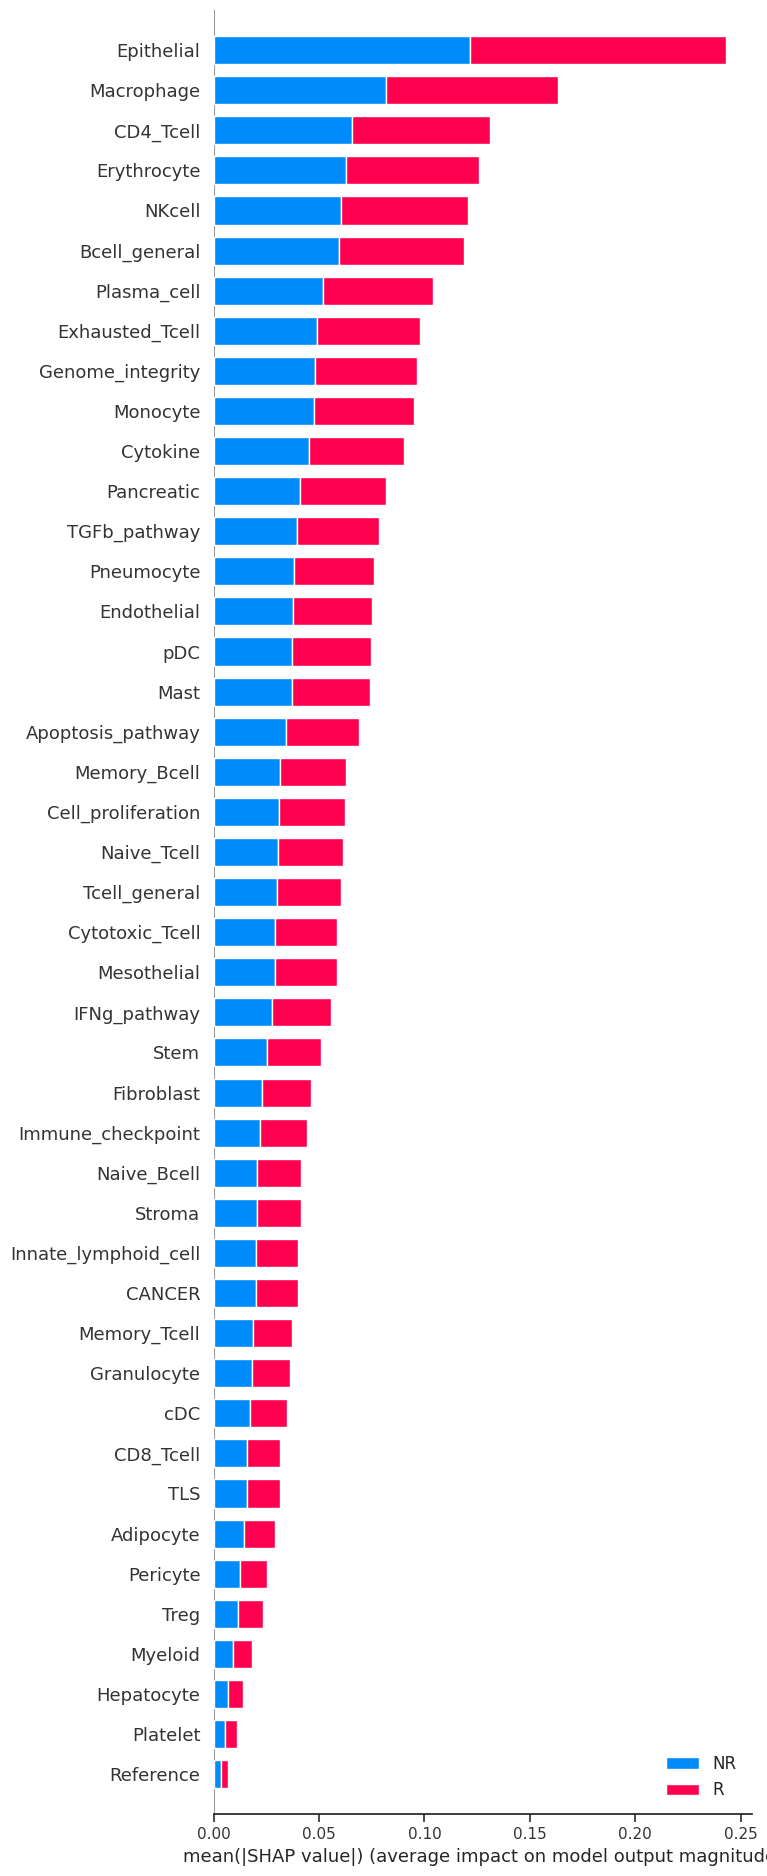

100%|##########| 13/13 [00:00<00:00, 13.44it/s]


  0%|          | 0/408 [00:00<?, ?it/s]

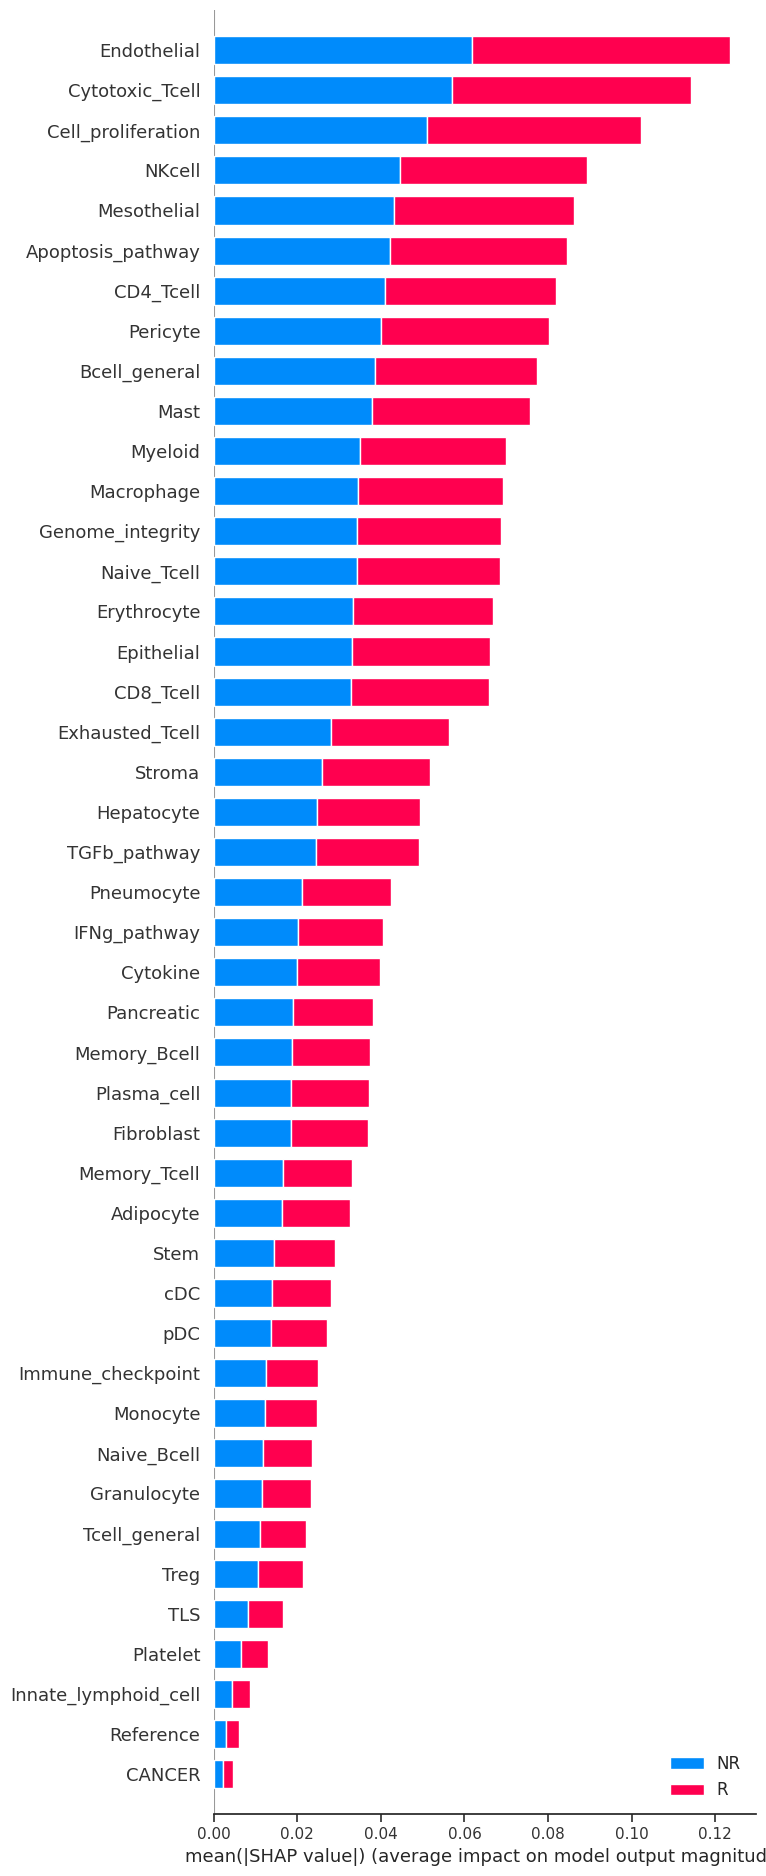

100%|##########| 7/7 [00:00<00:00, 10.55it/s]


  0%|          | 0/198 [00:00<?, ?it/s]

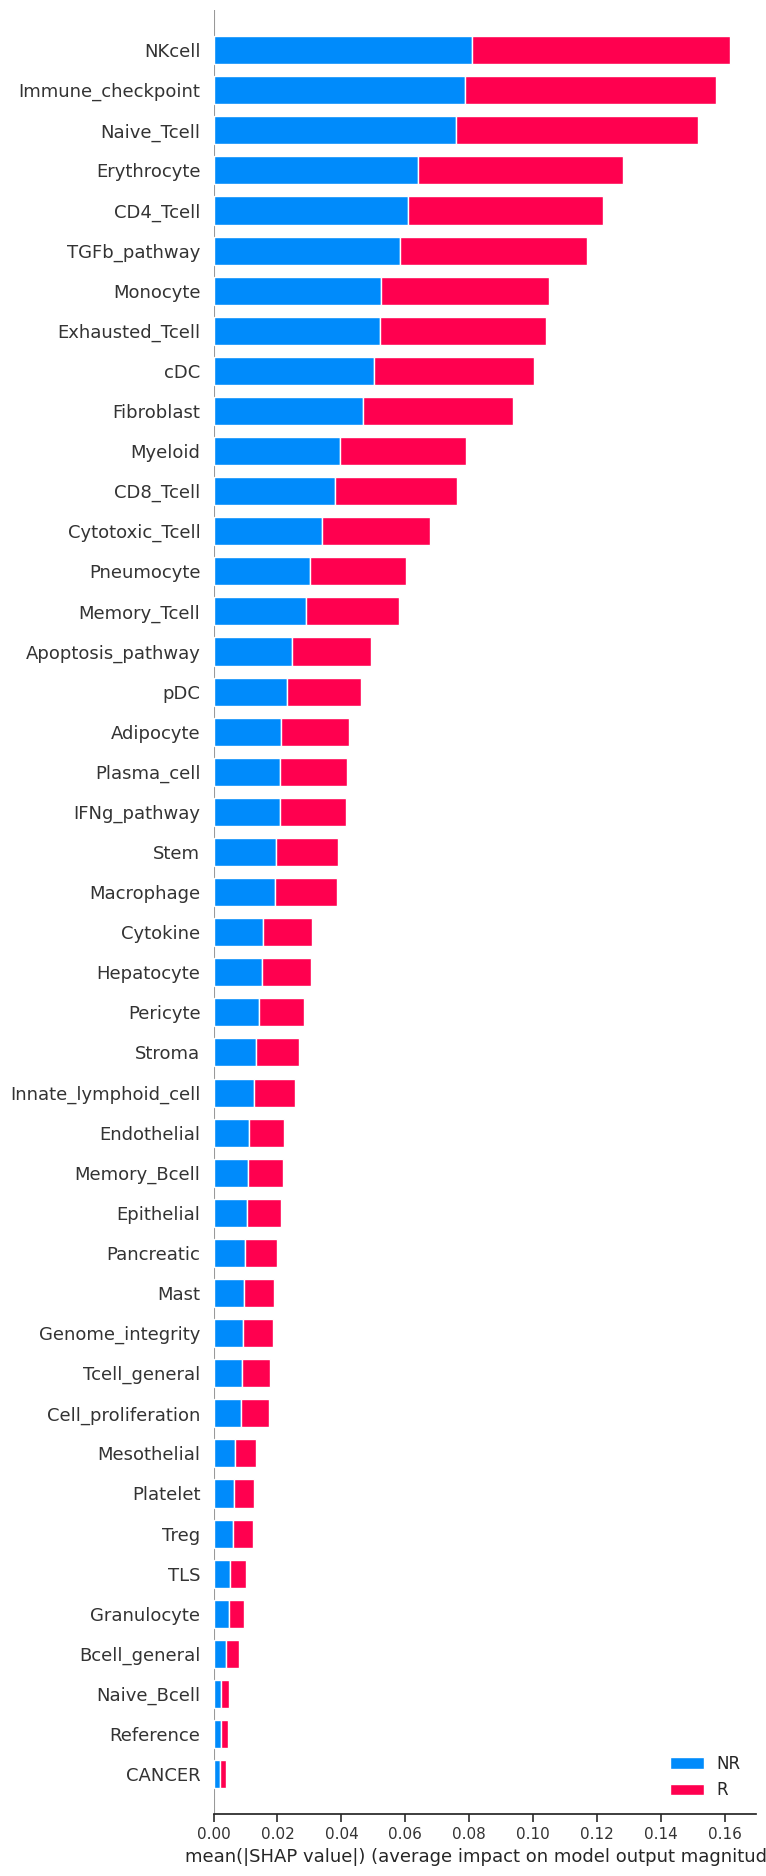

100%|##########| 11/11 [00:00<00:00, 12.24it/s]


  0%|          | 0/330 [00:00<?, ?it/s]

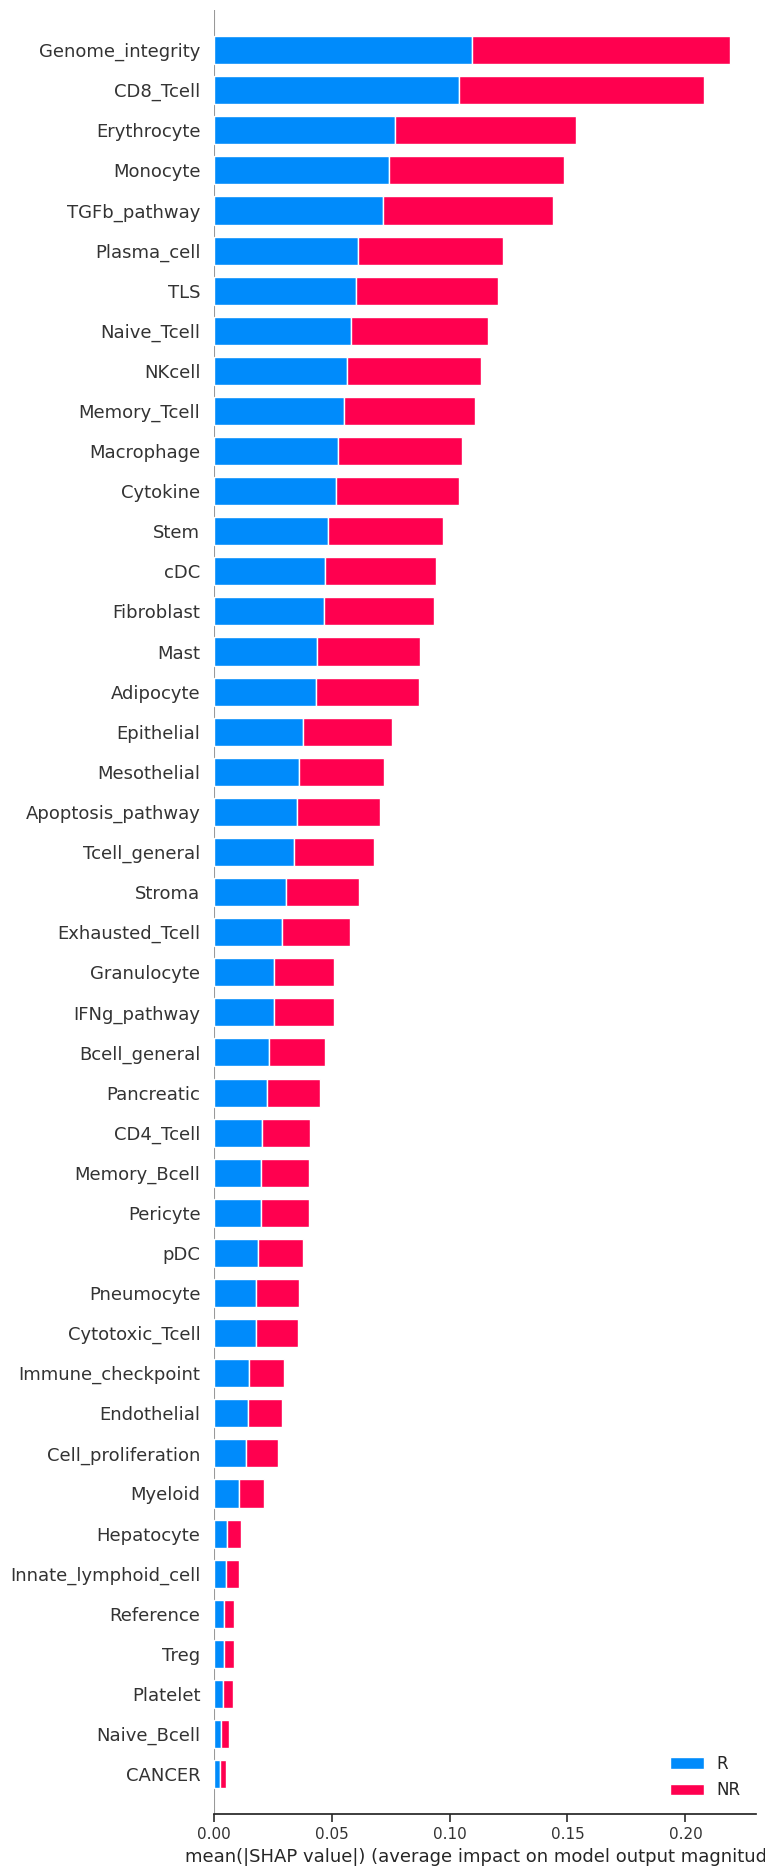

100%|##########| 4/4 [00:00<00:00,  6.98it/s]


  0%|          | 0/102 [00:00<?, ?it/s]

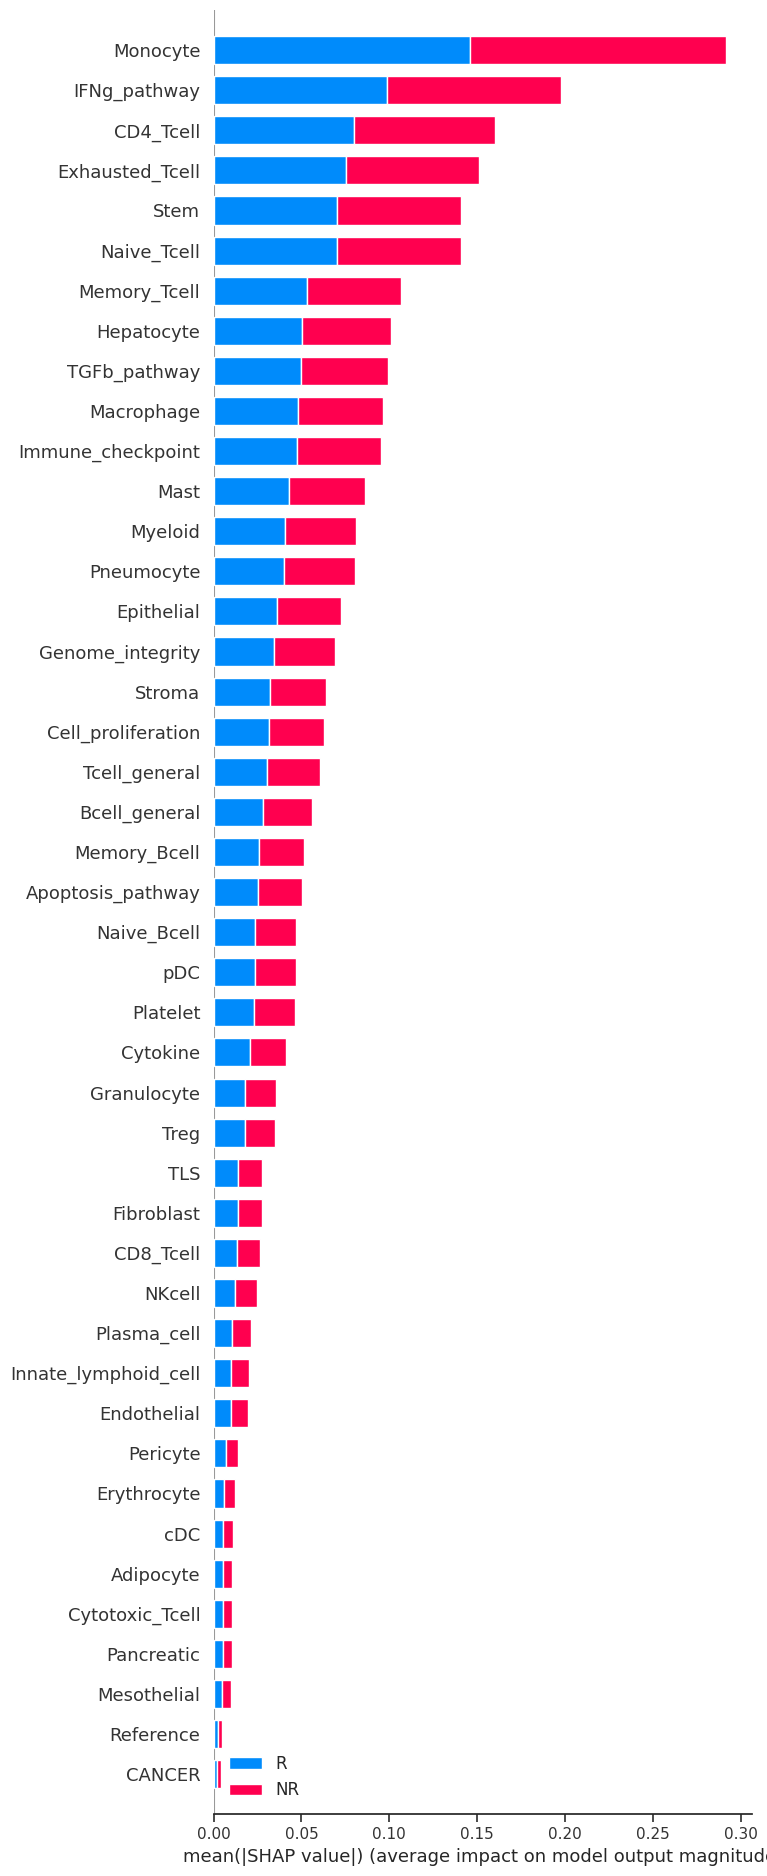

100%|##########| 2/2 [00:00<00:00,  4.66it/s]


  0%|          | 0/45 [00:00<?, ?it/s]

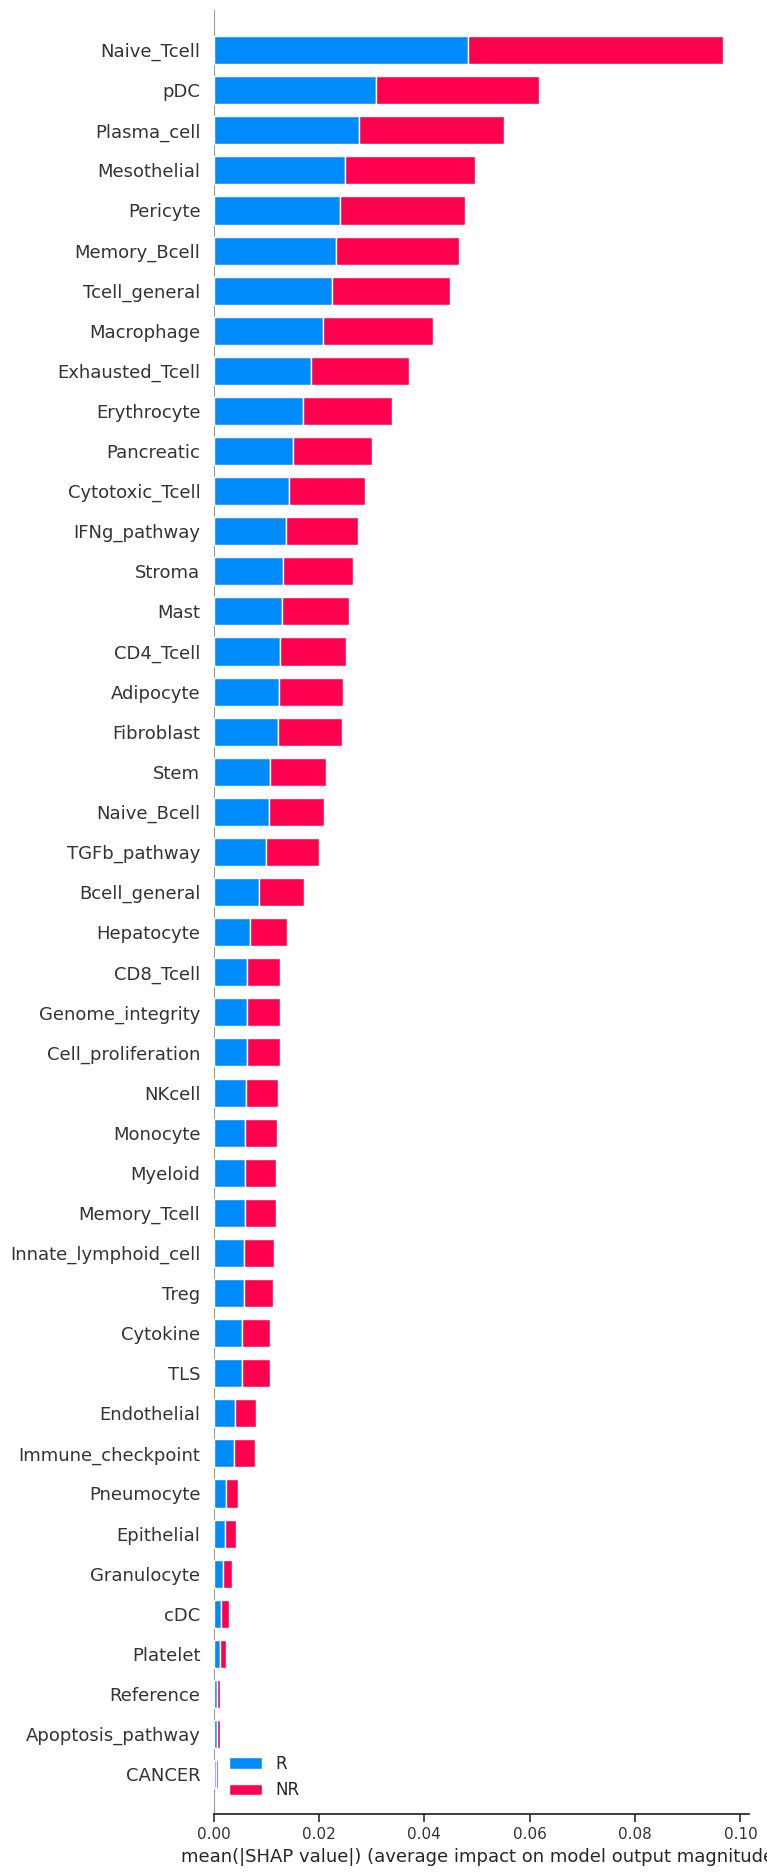

100%|##########| 1/1 [00:00<00:00,  1.74it/s]


  0%|          | 0/25 [00:00<?, ?it/s]

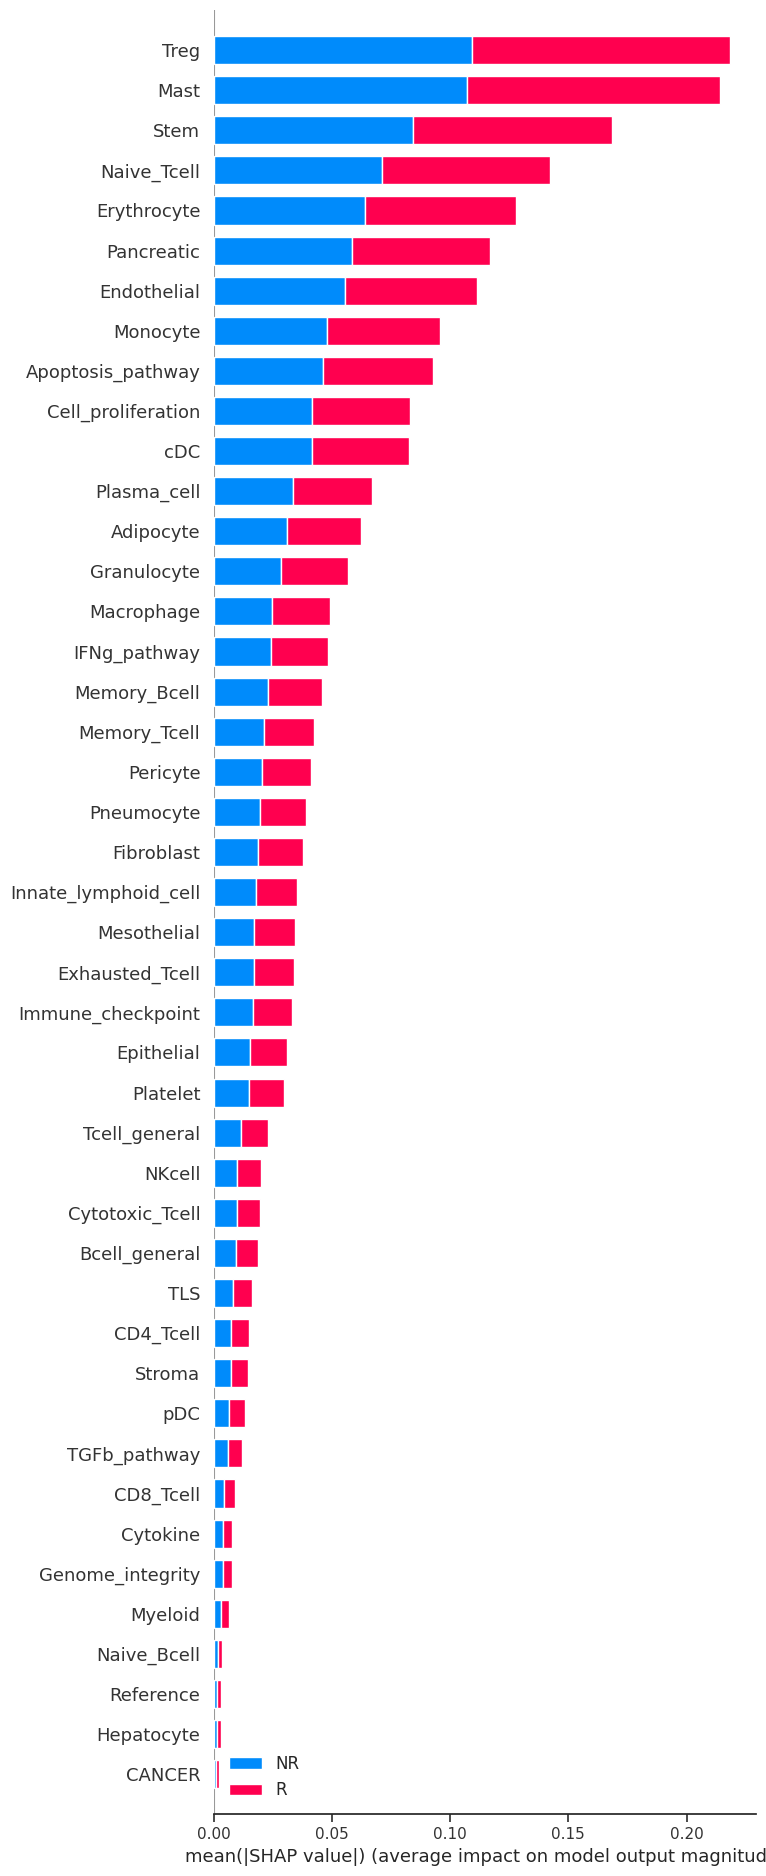

100%|##########| 1/1 [00:00<00:00,  2.58it/s]


  0%|          | 0/25 [00:00<?, ?it/s]

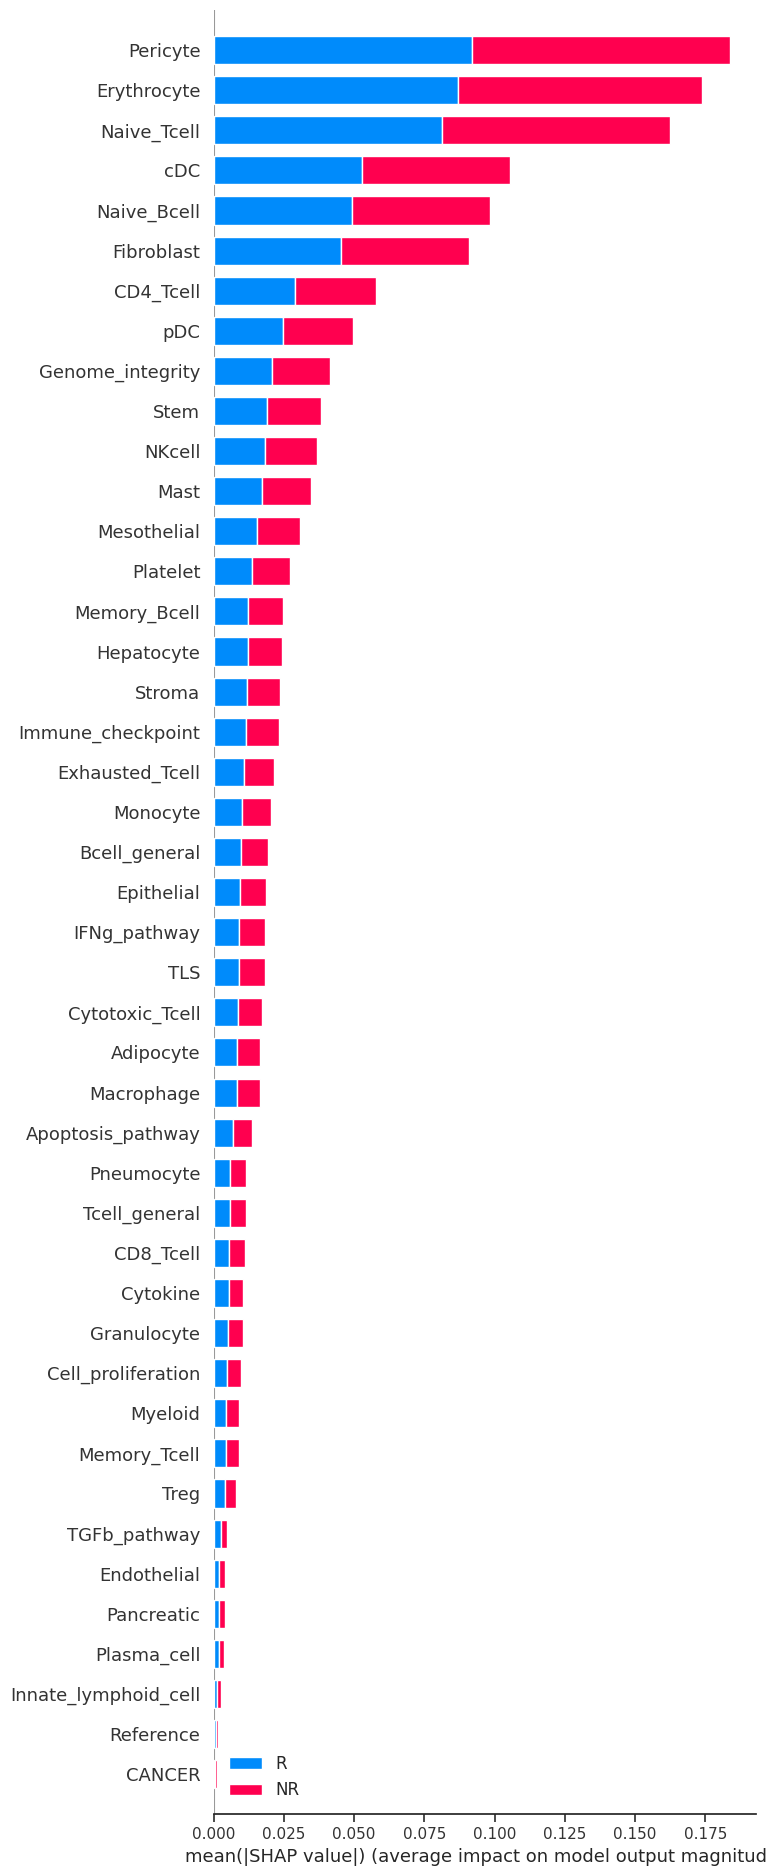

In [20]:
for cancer in ['all', 'BLCA', 'KIRC', 'SKCM', 'LUAD', 'STAD', 'GBM', 'LUSC' ]:
    if cancer  == 'all':
        idx = df_label.index
    else:
        idx = df_label[df_label.cancer_type == cancer].index

    if cancer != 'all':
        model_path = '/home/was966/Research/mims-conceptor/paper/checkpoint/latest/finetuner_pft_%s.pt' % cancer
    else:
        model_path = '/home/was966/Research/mims-conceptor/paper/checkpoint/latest/finetuner_pft_all_v100s2.pt'
        
    dfcx = dfcx_org.loc[idx]

    finetuner = loadcompass(model_path)
    device = finetuner.device
    
    dfg, dfc = finetuner.extract(dfcx, batch_size = 32,)
    _, dfy = finetuner.predict(dfcx, batch_size = 32,)
    
    model = finetuner.model.taskdecoder
    model.eval()
    
    def predict(data):
        model.eval()
        with torch.no_grad():
            data_tensor = torch.tensor(data, dtype=torch.float32)
            return model(data_tensor.to(device)).cpu().numpy()
            
    fname = dfc.columns[:]
    x = torch.tensor(dfc[fname].values).to(device)
    
    K = 100
    background = x.cpu().numpy() if len(x) < K else shap.kmeans(x.cpu().numpy(), k = K).data
    
    e = KernelExplainer(predict, background)
    shap_values = e.shap_values(x.cpu().numpy(), check_additivity=True)
    
    df1 = pd.DataFrame(shap_values[1], columns = fname, index=dfcx.index)
    df1.to_csv('%s_shap_pft_r.csv' % cancer)
    
    df2 = pd.DataFrame(shap_values[0], columns = fname, index=dfcx.index)
    df2.to_csv('%s_shap_pft_nr.csv' % cancer)
    
    shap.summary_plot(shap_values, x.cpu().numpy(), feature_names = fname, show=False, 
                      class_names = {0:'NR', 1:'R'},  max_display = 50)
    plt.savefig('./results/%s_shap_bar_plot.svg' % cancer, bbox_inches='tight')
    plt.close()
    
    shap.summary_plot(shap_values[1], x.cpu().numpy(), feature_names = fname, 
                      cmap='bwr', plot_type='dot', 
                      class_names = {0:'NR', 1:'R'}, show = False,  max_display = 50)
    plt.savefig('./results/%s_shap_summary_plot.svg' % cancer, bbox_inches='tight')
    plt.close()

In [10]:
res = []
for cancer in ['all', 'BLCA', 'KIRC', 'SKCM', 'LUAD', 'STAD', 'GBM', 'LUSC' ]:
    df1 = pd.read_csv('./results/%s_shap_pft_nr.csv' % cancer, index_col=0)
    df2 = pd.read_csv('./results/%s_shap_pft_r.csv' % cancer, index_col = 0)    
    
    nr = df1.abs().mean().to_frame(name = 'NR')
    r = df2.abs().mean().to_frame(name = 'R')
    df = nr.join(r)
    df['group'] = cancer

    df['NR'] = df['NR'].rank(ascending = False)
    df['R'] = df['R'].rank(ascending = False)

    
    res.append(df)

In [11]:
dfa = pd.concat(res)
dfa.index.name = 'concept'
data = dfa.reset_index()

data['R/NR_mean'] = data[['R', 'NR']].mean(axis=1)
data['R/NR_std'] = data[['R', 'NR']].std(axis=1)

<Axes: xlabel='concept', ylabel='group'>

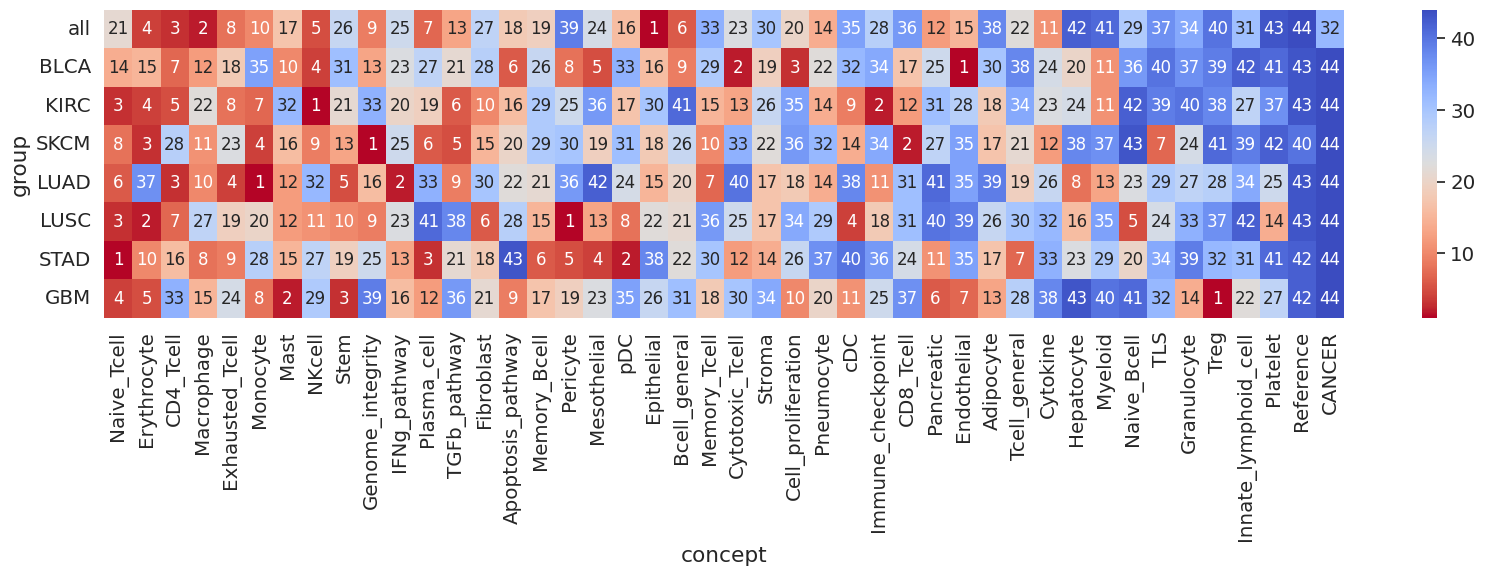

In [12]:
data1 = pd.pivot_table(data, values = 'R/NR_mean', index = 'concept', columns = 'group')
order = data1.mean(axis=1).sort_values(ascending=True).index

data1 = data1.loc[order][['all', 'BLCA', 'KIRC', 'SKCM', 'LUAD','LUSC', 'STAD','GBM']] # 
plt.figure(figsize=(20, 4))
sns.heatmap(data1.T, annot=True, annot_kws={'fontsize':12}, cmap = 'coolwarm_r',)

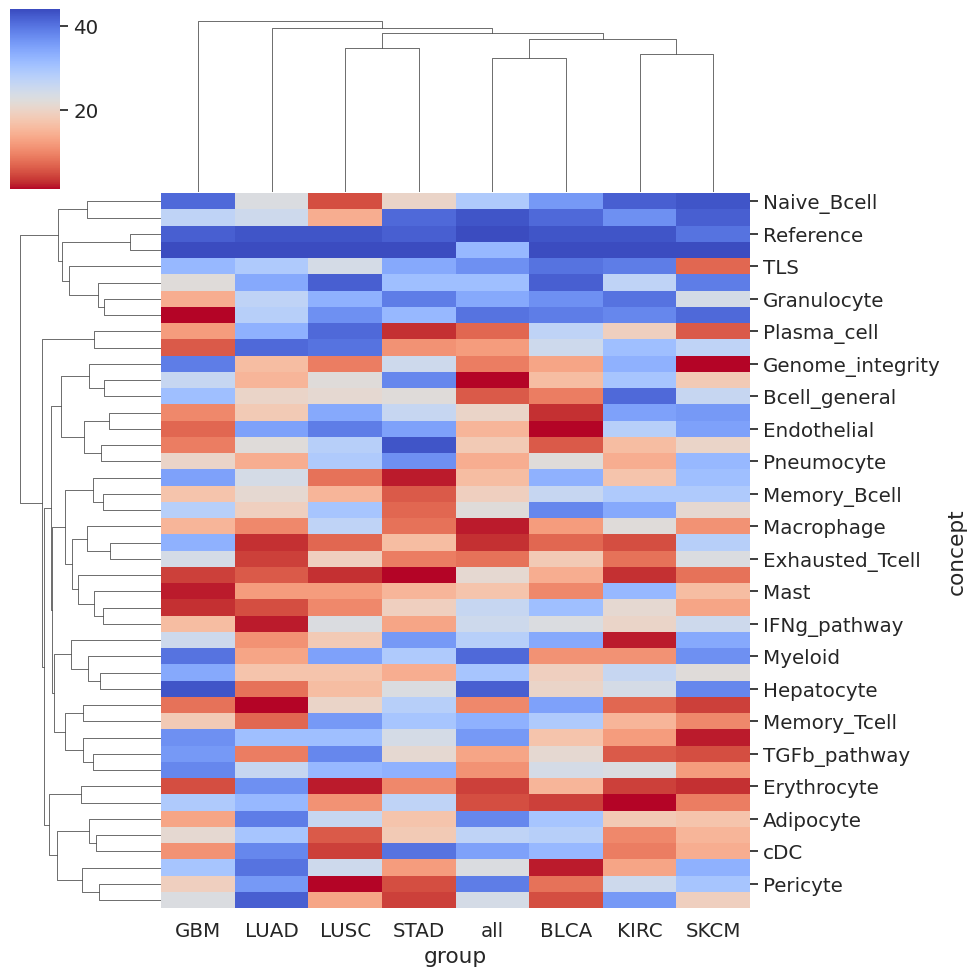

In [13]:
sns.clustermap(data1, cmap = 'coolwarm_r',)

In [14]:
import colorbm as cbm

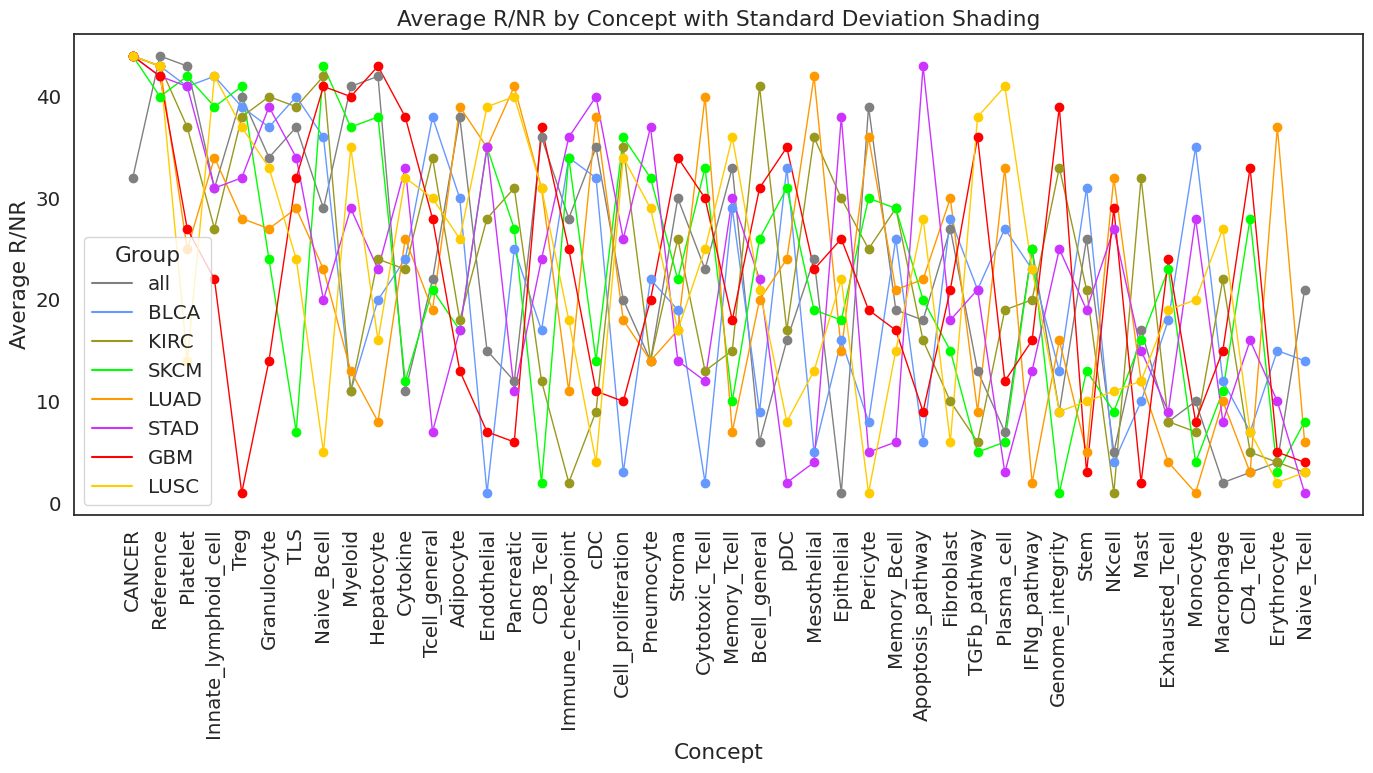

In [15]:
# Calculate mean and std for R and NR

# Define colors
cancer_order = ['GBM', 'LUAD', 'LUSC', 'SKCM', 'BLCA', 'STAD', 'KIRC']
cancer_color = cbm.palettes.ucscgb
cancer_map = dict(zip(cancer_order, cancer_color))
cancer_map['all'] = 'grey'

# Define a function to create the plot with specified x-axis sorting
def create_plot(data, sort_by='all'):
    if sort_by == 'all':
        # Sort by R/NR_mean for All group
        sorted_data = data[data['group'] == 'all'].sort_values(by='R/NR_mean', ascending=False)
    else:
        # Sort by the average R/NR_mean across all groups
        sorted_data = data.groupby('concept')['R/NR_mean'].mean().sort_values(ascending=False).reset_index()
    
    sorted_concepts = sorted_data['concept'].tolist()
    data['concept'] = pd.Categorical(data['concept'], categories=sorted_concepts, ordered=True)

    # Plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=data,
        x='concept',
        y='R/NR_mean',
        hue='group',
        style= None,
        markers=True,
        palette=cancer_map,
        err_style="bars",
        ci=None,
        linewidth=1,
        marker='o'
    )

    #Add error bars manually
    for group in data['group'].unique():
        group_data = data[data['group'] == group]
        plt.errorbar(
            x=group_data['concept'],
            y=group_data['R/NR_mean'],
            yerr=group_data['R/NR_std'],
            fmt='o',
            color=cancer_map.get(group, 'black')
        )
    
    plt.xticks(rotation=90)
    plt.xlabel('Concept')
    plt.ylabel('Average R/NR')
    plt.title('Average R/NR by Concept with Standard Deviation Shading')
    plt.legend(title='Group')
    plt.tight_layout()

    # Save the plot as a PDF
    #plt.savefig('/mnt/data/concept_plot_with_shading.pdf', format='pdf')
    plt.show()

# Example usage:
create_plot(data, sort_by=None)